# Week 4 - Static Attitude Determination

This week, we dive into the fascinating world of static attitude determination. Here, the focus is on taking a snapshot of multiple directional observations—like the sun’s heading, magnetic field direction, and star positioning—to compute a spacecraft's 3D orientation. Essentially, we’re using known vectors in both the spacecraft and reference frames to figure out “which way is up” in space.

We’ll cover both classic and modern algorithms that are fundamental in the field of attitude determination. These include:

- **TRIAD Method**: A foundational, straightforward technique for calculating attitude based on two vector observations.
- **Devenport’s q-Method**: A method that minimizes a cost function to estimate attitude, using quaternions as the rotation representation.
- **QUEST (QUaternion ESTimator)**: An optimized version of the q-method, designed for real-time applications and quick computations.
- **OLAE (Optimal Linear Attitude Estimation)**: A linearized approach that simplifies calculations, particularly useful in scenarios with multiple observations.

Throughout the module, we’ll not only dive into how these methods work, but also discuss the pros and cons of each, especially in terms of computational efficiency and accuracy.

<ins>**Learning Objectives**</ins>

- **Determine attitude from a series of heading measurements**: Learn how to combine various directional observations to calculate a reliable orientation in 3D space.
- **Describe various classical and modern algorithms used in attitude determination**: Gain an understanding of the main methods used in both theoretical and practical applications.
- **Derive the fundamental attitude coordinate properties of rigid bodies**: Develop a mathematical grasp of the key properties that govern the rotational dynamics of rigid bodies in space.

---

In [1]:
# Import Relevant Libraries
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot

import sys
sys.path.insert(0, r"../")
from AttitudeKinematicsLib import *

# 4.1) Attitude Determination Problem Statement

Attitude determination involves finding the orientation of an object (such as a spacecraft) in space, using instantaneous measurements of specific reference directions. This topic focuses on determining attitude without relying on dynamic filtering or rate measurements (e.g., gyroscopes), which are covered in more advanced topics like Kalman filters and require estimation theory. Here, the aim is to determine the orientation based solely on direct observations.


**<ins>Understanding Attitude Determination</ins>**

- **Objective**: The goal of attitude determination is to compute the orientation (attitude) of a spacecraft by aligning measured body-frame vectors with their corresponding known inertial-frame references. This orientation is typically represented as a Direction Cosine Matrix (DCM), $[\mathbf{B}\mathbf{N}]$, which maps vectors in the inertial frame ($\mathcal{^N}\hat{v}$) to the body frame ($\mathbf{^B}\hat{v}$).

- **Challenge**: Each sensor measurement provides partial information about the spacecraft’s 3D attitude. To resolve the full attitude, multiple independent observations are required. The problem involves relating noisy body-frame sensor measurements to accurate, well-known inertial-frame vectors.

---

**<ins>Inertial and Body Frame Vectors</ins>**

- **Inertial Frame Vectors ($\mathcal{^N}\hat{v}$)**:
  - These are **known reference directions** in an inertial coordinate system, such as the Sun’s direction, Earth’s magnetic field, or positions of stars.
  - They are computed using:
    1. **Position in Orbit**: Derived from GPS or ground-based tracking systems.
    2. **Time in Orbit**: Provided by onboard clocks or ground communication.
  - Using position and time, precise models (e.g., solar ephemeris, magnetic field models like IGRF) yield these vectors in the inertial frame.

<br>

- **Body Frame Vectors ($\mathbf{^B}\hat{v}$)**:
  - These are **measured directions** relative to the spacecraft’s body, obtained via onboard sensors:
    - **Sun Sensors**: Measure the Sun’s direction.
    - **Magnetometers**: Detect the Earth’s magnetic field.
    - **Star Trackers**: Determine the positions of stars.
  - Each sensor provides a body-frame vector pointing to a known reference object.

---

**<ins>Relating Inertial and Body Vectors</ins>**

- The relationship between measured body-frame vectors and their known inertial counterparts is described by the DCM:
  $$
  \mathbf{^B}\hat{v}_k = [\mathbf{B}\mathbf{N}] \mathcal{^N}\hat{v}_k, \quad k = 1, \dots, N
  $$
  where:
  - $\mathcal{^N}\hat{v}_k$: Known inertial-frame vector, derived from position, time, and reference models.
  - $\mathbf{^B}\hat{v}_k$: Measured body-frame vector, obtained from sensors.
    
- Conversely, the inverse DCM maps vectors from the body frame back to the inertial frame:
  $$
  \mathcal{^N}\hat{v}_k = [\mathbf{B}\mathbf{N}]^T \mathbf{^B}\hat{v}_k
  $$

---

**<ins>Key Insight</ins>**

- **Why Are Vectors Different?**:
  - The difference between body and inertial vectors reflects the spacecraft’s orientation in space.
  - If the body and inertial vectors match, it means the spacecraft's body and inertial frames coincide, i.e., no rotation.

<br>

- **Orientation Representation**:
  - The DCM, $[\mathbf{B}\mathbf{N}]$, represents how the body is oriented with respect to the inertial frame.
  - In practice, the spacecraft estimates $[\bar{\mathbf{B}}\mathbf{N}]$, an approximation of $[\mathbf{B}\mathbf{N}]$, based on body-frame sensor measurements and inertial-frame references.
  - This estimate allows us to determine how the body is oriented relative to the inertial frame, enabling precise navigation and control.

# 4.2) TRIAD Method

The Vector Triad Method is a deterministic approach to estimate a spacecraft's attitude at a given instant using two vector observations. This method introduces an intermediate frame, or "triad" frame, to simplify the problem. By aligning a third frame with both the inertial frame (e.g., stars or magnetic field) and the body frame (sensor measurements), the method allows a straightforward matrix solution to attitude estimation. Here’s an overview of the method and its key steps.

**<ins>Why Use the Vector Triad Method?</ins>**

- **Simple and Efficient**: The triad method is computationally inexpensive, making it suitable for missions with limited processing power.
- **Reliable for Limited Measurements**: When only two measurements are available (e.g., sun and magnetic field directions), this method provides a quick way to estimate attitude.
- **Optimal Choice of Measurement**: For the triad method, the measurement with the highest accuracy (usually the sun heading) is assigned as the primary reference axis. Less accurate measurements, such as the magnetic field, are used as secondary references.
le.

**<ins>Steps in the Vector Triad Method</ins>**

1. **Define Two Frames**:
   - **Inertial Frame**: Denoted as the $N$ frame, representing known directions in space, such as the position of the sun or Earth's magnetic field. These directions are assumed to be known because we generally know the satellite or spacecraft's position in its orbit relative to the Earth.

   - **Body Frame**: Denoted as the $B$ frame, representing measurements in the body’s coordinate system, such as sensor readings of the sun and magnetic field. Both the sun sensor and the magnetometer (MTM) provide vectors known in both the body frame and the inertial frame.

   - **Triad Frame**: An intermediate frame denoted as $T$, introduced to mitigate the effects of sensor noise. Determining the body frame attitude directly from noisy sensor data can lead to inaccuracies. Instead, the triad frame serves as a bridge between the inertial and body frames, stabilizing the attitude estimation process.

<br>

2. **Align the Primary Axis**:
   - Select the most accurate measurement (e.g., the sun heading) and align it with the first axis ($\mathbf{t}_1$) of the triad frame. The sun sensor typically provides a more precise measurement than the magnetic field sensor due to the variability of the Earth's magnetic field.

   - If the sun vector in the body frame is $\mathbf{s}_b$ and the sun vector in the inertial frame is $\mathbf{s}_n$, then:
     $$ \mathbf{t}_1 = \mathbf{s} $$

<br>

3. **Calculate the Orthogonal Vector for the Second Axis**:
   - Use the secondary measurement (e.g., magnetic field) to define a second axis orthogonal to the first axis.

   - For example, if $\mathbf{m}_b$ is the magnetic field in the body frame and $\mathbf{m}_n$ is the magnetic field in the inertial frame, calculate $\mathbf{t}_2$ as:
     $$ \mathbf{t}_2 = \frac{\mathbf{s} \times \mathbf{m}}{|\mathbf{s} \times \mathbf{m}|} $$

   - $\mathbf{t}_2$ is normalized to make it a unit vector, preseriving the directionality of the vector only.

<br>

4. **Define the Third Axis**:
   - Complete the triad by defining the third axis as the cross product of the first two:
     $$ \mathbf{t}_3 = \mathbf{t}_1 \times \mathbf{t}_2 $$

<br>

5. **Construct Transformation Matrices**:
   - The **T frame direction axes** can be computed using both **B** (body frame) and **N** (inertial frame) components:

     **Body Frame Triad Vectors**
     $$
     \mathbf{^B}\hat{t}_1 = \mathbf{^B}\hat{s}
     $$
     $$
     \mathbf{^B}\hat{t}_2 = \frac{\mathbf{^B}\hat{s} \times \mathbf{^B}\hat{m}}{|\mathbf{^B}\hat{s} \times \mathbf{^B}\hat{m}|}
     $$
     $$
     \mathbf{^B}\hat{t}_3 = \mathbf{^B}\hat{t}_1 \times \mathbf{^B}\hat{t}_2
     $$

     **Inertial Frame Triad Vectors**
     $$
     \mathcal{^N}\hat{t}_1 = \mathcal{^N}\hat{s}
     $$
     $$
     \mathcal{^N}\hat{t}_2 = \frac{\mathcal{^N}\hat{s} \times \mathcal{^N}\hat{m}}{|\mathcal{^N}\hat{s} \times \mathcal{^N}\hat{m}|}
     $$
     $$
     \mathcal{^N}\hat{t}_3 = \mathcal{^N}\hat{t}_1 \times \mathcal{^N}\hat{t}_2
     $$

   - In the absence of measurement errors, both sets of **Triad frame representations** should be identical.

   - Construct the **Body to Triad Matrix** ($[\bar{\mathbf{B}}\mathbf{T}]$) and **Inertial to Triad Matrix** ($[\mathcal{N}\mathbf{T}]$):
     $$
     [\bar{\mathbf{B}}\mathbf{T}] = \begin{bmatrix} \mathbf{^B}\hat{t}_1 & \mathbf{^B}\hat{t}_2 & \mathbf{^B}\hat{t}_3 \end{bmatrix}
     $$
     $$
     [\mathcal{N}\mathbf{T}] = \begin{bmatrix} \mathcal{^N}\hat{t}_1 & \mathcal{^N}\hat{t}_2 & \mathcal{^N}\hat{t}_3 \end{bmatrix}
     $$

<br>

6. **Calculate the Attitude Matrix**:
   - The final step is to compute the attitude matrix, $[\bar{\mathbf{B}}\mathbf{N}]$, that transforms from the inertial frame to the body frame:
     $$
     \bar{\mathbf{B}}\mathbf{N} = [\bar{\mathbf{B}}\mathbf{T}] \cdot [\mathcal{N}\mathbf{T}]^T
     $$
   - This product provides the full attitude matrix, which can then be used to extract desired attitude parameters (Euler angles, MRPs, etc.).

<br>

**Estimation Error Assessment**:
   - If the **actual orientation** ($[\mathbf{B}\mathbf{N}]$) is known, the estimation error can be computed as:
     $$
     [\bar{\mathbf{B}}\mathbf{B}] = [\bar{\mathbf{B}}\mathbf{N}] \cdot ([\mathbf{B}\mathbf{N}])^T
     $$
   - Here, $[\bar{\mathbf{B}}\mathbf{B}]$ represents the error matrix. If the estimation is perfect, $[\bar{\mathbf{B}}\mathbf{B}]$ will be the identity matrix.

   - To quantify the error, you can use **axis-angle formalism** to extract the rotation axis and angle from $[\bar{\mathbf{B}}\mathbf{B}]$. This will give a measure of how far the estimated body frame is from the true body frame in terms of rotation angle (radians or degrees).

   - This process allows for a precise evaluation of the accuracy of the attitude estimation.

**<ins>Important Considerations</ins>**

- **Measurement Accuracy**: The triad method assumes that the first measurement vector (e.g., sun heading) is more accurate. Aligning this vector with the primary axis ($\mathbf{t}_1$) uses its full information, while the secondary measurement provides additional orientation constraints.
- **Non-Collinearity of Measurements**: The two measurement vectors must not be collinear, as this would fail to constrain the third axis. For example, if the sun vector and magnetic field vector are aligned, the system would lose orientation around that axis.

**<ins>Practical Usage and Limitations</ins>**

- **Efficiency**: This method is fast and computationally light, making it suitable for real-time systems or constrained spacecraft systems.
- **Usage on Spacecraft**: The triad method has been implemented on various spacecraft where simplicity is prioritized, particularly for missions without advanced filtering methods.
- **Accuracy and Redundancy**: While effective, the method does not use all available data when only two measurements are used. As missions typically involve more sensors, more advanced algorithms like QUEST or Kalman filters can be employed to improve attitude estimation accuracy and handle dynamic environments.

**<ins>Summary</ins>**

The vector triad method is a foundational approach in attitude determination, especially valuable for its simplicity and direct use of two sensor measurements. It is a fundamental tool in aerospace engineering for quick and reliable orientation estimation when minimal data is available.

In [2]:
def triad_estimation(r1_b, r1_i, r2_b, r2_i):
    """
    Implements the TRIAD algorithm to compute the rotation matrix from the inertial frame to the body frame.

    Args:
        r1_b (array-like): First reference vector measured in the body frame (3-element array).
        r1_i (array-like): First reference vector in the inertial frame (3-element array).
        r2_b (array-like): Second reference vector measured in the body frame (3-element array).
        r2_i (array-like): Second reference vector in the inertial frame (3-element array).

    Returns:
        numpy.ndarray: Rotation matrix from the inertial frame to the body frame (3x3 matrix).
    """
    # Validate input vectors
    validate_vec3(r1_b)
    validate_vec3(r1_i)
    validate_vec3(r2_b)
    validate_vec3(r2_i)
    
    # Convert inputs to NumPy arrays and normalize the vectors
    r1_b = np.asarray(r1_b, dtype=float)
    r1_i = np.asarray(r1_i, dtype=float)
    r2_b = np.asarray(r2_b, dtype=float)
    r2_i = np.asarray(r2_i, dtype=float)

    r1_b /= np.linalg.norm(r1_b)
    r1_i /= np.linalg.norm(r1_i)
    r2_b /= np.linalg.norm(r2_b)
    r2_i /= np.linalg.norm(r2_i)

    # Construct the body-frame TRIAD vectors (estimated)
    t1_b = r1_b
    t2_b = np.cross(r1_b, r2_b)
    t2_b /= np.linalg.norm(t2_b)
    t3_b = np.cross(t1_b, t2_b)

    # Construct the inertial-frame TRIAD vectors
    t1_i = r1_i
    t2_i = np.cross(r1_i, r2_i)
    t2_i /= np.linalg.norm(t2_i)
    t3_i = np.cross(t1_i, t2_i)

    # Assemble the TRIAD matrices
    B_bar_T = np.column_stack((t1_b, t2_b, t3_b))  # Estimated body frame TRIAD matrix
    N_T = np.column_stack((t1_i, t2_i, t3_i))      # Inertial frame TRIAD matrix

    # Compute the rotation matrix from inertial frame to body frame
    C_BN = np.matmul(B_bar_T, N_T.T)

    return C_BN

# Example 3.15 from Textbook
v1_b = [0.8190, -0.5282, 0.2242]
v1_i = [1, 0, 0]
v2_b = [-0.3138, -0.1584, 0.9362]
v2_i = [0, 0, 1]
B_bar_N = triad_estimation(v1_b, v1_i, v2_b, v2_i)
print(B_bar_N)

[[ 0.81899104  0.45928237 -0.34396712]
 [-0.52819422  0.83763943 -0.13917991]
 [ 0.22419755  0.29566855  0.92860948]]


In [3]:
# Concept Check 2 - TRIAD Method, Q1
v1_b = [0.8273, 0.5541, -0.0920]
v1_i = [-0.1517, -0.9669, 0.2050]
v2_b = [-0.8285, 0.5522, -0.0955]
v2_i = [-0.8393, 0.4494, -0.3044]
B_bar_N = triad_estimation(v1_b, v1_i, v2_b, v2_i)
print(B_bar_N)

[[ 0.41555875 -0.85509088  0.31004921]
 [-0.83393237 -0.49427603 -0.24545471]
 [ 0.36313597 -0.15655922 -0.91848869]]


In [4]:
# Concept Check 2 - TRIAD Method, Q2

# Estimated attitude matrix (B_bar_N)
B_bar_N = np.array([
    [0.969846,  0.171010,  0.173648],
    [-0.200706, 0.964610,  0.171010],
    [-0.138258, -0.200706, 0.969846]
])

# True attitude matrix (BN)
BN = np.array([
    [0.963592,  0.187303,  0.190809],
    [-0.223042, 0.956645,  0.187303],
    [-0.147454, -0.223042, 0.963592]
])


B_bar_B = np.matmul(B_bar_N, BN.T)
axis, phi = DCM_to_PRV(B_bar_B)
print(phi)

1.8349476067250545


# 4.3) Wahba's Problem Defintion

**<ins>Wahba's Problem</ins>**

- **Objective**: To determine the optimal orientation (attitude) of a spacecraft by minimizing the error between measured body-frame vectors and their known inertial-frame counterparts. The orientation is represented as the Direction Cosine Matrix (DCM), $[\bar{\mathbf{B}}\mathbf{N}]$, which relates vectors in the inertial frame ($\mathcal{^N}\hat{v}$) to the body frame ($\mathbf{^B}\hat{v}$).

- **Challenge**: Sensor measurements are noisy and provide only partial information about the spacecraft's 3D attitude. The goal is to compute $[\bar{\mathbf{B}}\mathbf{N}]$ that minimizes the mismatch between measured and known vectors while accounting for sensor noise and variability.

---

**<ins>Mathematical Formulation</ins>**

1. **Mapping from Inertial to Body Frame**:  
   $$
   \mathbf{^B}\hat{v}_k = [\bar{\mathbf{B}}\mathbf{N}] \mathcal{^N}\hat{v}_k, \quad k = 1, \dots, N
   $$
   where:  
   - $\mathcal{^N}\hat{v}_k$: A known reference vector in the **inertial frame**, derived from models or ephemeris data (e.g., Sun direction, Earth's magnetic field).  
   - $\mathbf{^B}\hat{v}_k$: The corresponding vector **measured in the body frame** by onboard sensors (e.g., sun sensors, magnetometers).  
   - $N$: The number of vector pairs (observations) available.

<br>

2. **Error Minimization**:
   Wahba proposed a least squares approach to solve the attitude determination problem. The goal is to find $[\bar{\mathbf{B}}\mathbf{N}]$ that minimizes the cost function:
   $$
   J([\bar{\mathbf{B}}\mathbf{N}]) = \frac{1}{2} \sum_{k=1}^N w_k \| \mathbf{^B}\hat{v}_k - [\bar{\mathbf{B}}\mathbf{N}] \mathcal{^N}\hat{v}_k \|^2
   $$
   where:
   - $w_k$: Weight assigned to each observation, reflecting its accuracy or reliability.
   - $\|\cdot\|$: Euclidean norm.

   The factor of $\frac{1}{2}$ simplifies derivative calculations, canceling out a factor of 2 during optimization.

<br>

3. **Perfect Measurements**:
   If all measurements are noise-free, the cost function becomes zero:
   $$
   J = 0
   $$

---

**<ins>Why Multiple Measurements?</ins>**

- Each measurement vector provides only two independent pieces of information (e.g., azimuth and elevation). Therefore:
  - A single vector cannot resolve all three degrees of freedom for 3D orientation.
  - At least two independent reference vectors are needed to compute the attitude matrix uniquely.
  - When $N > 2$, the problem becomes over-specified, and the least squares approach improves robustness against noise.

---

**<ins>Analogy to Least Squares Fitting</ins>**

- The cost function $J([\bar{\mathbf{B}}\mathbf{N}])$ resembles the least squares regression problem:
  - In regression, we minimize the squared error between predicted and observed data.
  - In Wahba's problem, we minimize the squared angular error between measured body-frame vectors and their corresponding inertial-frame references.

Thus, the DCM $[\bar{\mathbf{B}}\mathbf{N}]$ is the "best-fit rotation matrix" that aligns the reference vectors with the observations.

---

**<ins>Importance of Weights</ins>**

- Sensors vary in accuracy:
  - **Sun Sensors**: Typically more accurate and reliable.
  - **Magnetometers (MTM)**: More prone to noise due to environmental variations.
- The weights $w_k$ reflect the reliability of each sensor. Higher weights are assigned to more reliable measurements, ensuring they contribute more to the solution.
- Scaling all weights $w_k$ uniformly does not affect the result because the optimization is relative.

---

**<ins>Estimation Accuracy Check</ins>**

1. **Compute Estimation Error**:
   After estimating $[\bar{\mathbf{B}}\mathbf{N}]$, compare it to the true DCM $[\mathbf{B}\mathbf{N}]$ (if known):
   $$
   [\mathbf{B}\bar{\mathbf{B}}] = [\bar{\mathbf{B}}\mathbf{N}] \cdot [\mathbf{B}\mathbf{N}]^T
   $$
   - $[\mathbf{B}\bar{\mathbf{B}}]$: The "error DCM" quantifies the deviation between estimated and true attitudes.

<br>

2. **Error in Terms of Axis-Angle**:
   - If the estimate is perfect:
     $$
     [\mathbf{B}\bar{\mathbf{B}}] = \mathbf{I}
     $$
   - Otherwise, compute the axis and angle of rotation using axis-angle formalism. The rotation angle represents the magnitude of the estimation error.

---

**<ins>Conclusion</ins>**

Wahba's problem frames attitude determination as an optimization challenge, balancing the alignment of noisy measurements with known inertial references. By minimizing a weighted cost function, the method finds the best-fit DCM $[\bar{\mathbf{B}}\mathbf{N}]$, enabling accurate attitude estimation in real-world scenarios. This problem forms the foundation for advanced algorithms like Devenport's $q$-method,  QUEST, and other robust solutions in spacecraft navigation and control.

Known Rotation Matrix C_known:
[[ 0.81379768  0.04000876  0.57976947]
 [ 0.29619813  0.82976947 -0.47302146]
 [-0.5         0.5566704   0.66341395]]

Estimated Rotation Matrix C_estimated:
[[ 0.81379768  0.04000876  0.57976947]
 [ 0.29619813  0.82976947 -0.47302146]
 [-0.5         0.5566704   0.66341395]]

Rotation Matrix Error (Frobenius Norm): 5.946838538569096e-16

Orthogonality Check (C_estimated @ C_estimated^T):
[[ 1.00000000e+00  2.25411344e-16 -6.06146727e-16]
 [ 2.25411344e-16  1.00000000e+00  8.49399046e-17]
 [-6.06146727e-16  8.49399046e-17  1.00000000e+00]]
Determinant of C_estimated: 0.9999999999999994

Angular Deviations (degrees):
[2.25887274e-06 0.00000000e+00 2.09130979e-06 1.90909591e-06
 2.09130979e-06]

Residual Norms for Each Vector:
[2.28878340e-16 4.97282017e-16 4.74287484e-16 4.73589040e-16
 3.72380123e-16]
Root Mean Square Error (RMSE): 4.2132572955683827e-16


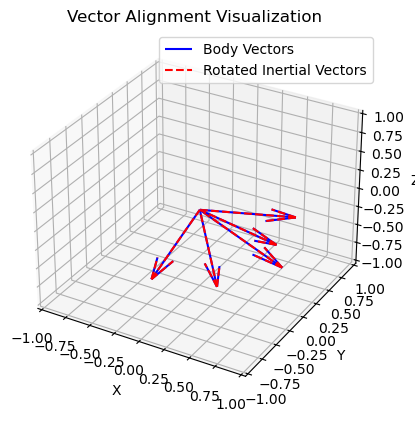

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

def wahba_solver(v_b, v_i, weights=None):
    """
    Solves Wahba's problem by maximizing the weighted sum of dot products
    between the body-frame and inertial-frame vectors.

    Args:
        v_b (numpy.ndarray): Array of shape (N, 3) containing N body-frame vectors (^B v_k).
        v_i (numpy.ndarray): Array of shape (N, 3) containing N inertial-frame vectors (^N v_k).
        weights (numpy.ndarray, optional): Array of shape (N,) containing weights w_k for each vector.

    Returns:
        numpy.ndarray: Optimal rotation matrix [B_bar N] (3x3) from inertial frame to body frame.
    """
    # Validate input dimensions
    if v_b.shape != v_i.shape:
        raise ValueError("Input vector arrays must have the same shape.")
    
    N = v_b.shape[0]
    
    if weights is None:
        weights = np.ones(N)
    else:
        weights = np.asarray(weights, dtype=float)
        if weights.shape[0] != N:
            raise ValueError("Weights array must have the same length as the number of vectors.")
    
    # Normalize the input vectors to unit length
    v_b = v_b / np.linalg.norm(v_b, axis=1, keepdims=True)
    v_i = v_i / np.linalg.norm(v_i, axis=1, keepdims=True)
    
    # Construct the weighted attitude profile matrix B
    B = np.zeros((3, 3))
    for k in range(N):
        B += weights[k] * np.outer(v_b[k], v_i[k])
    
    # Compute the SVD of B
    U, _, Vt = np.linalg.svd(B)
    
    # Compute the optimal rotation matrix [B_bar N]
    d = np.linalg.det(U @ Vt)
    W = np.eye(3)
    W[2, 2] = d  # Adjust for proper rotation
    
    C = U @ W @ Vt  # Equivalent to [B_bar N]
    
    return C

def angle_between_vectors(v1, v2):
    """
    Computes the angle in degrees between corresponding pairs of vectors in v1 and v2.

    Args:
        v1 (numpy.ndarray): Array of shape (N, 3) containing N vectors.
        v2 (numpy.ndarray): Array of shape (N, 3) containing N vectors.

    Returns:
        numpy.ndarray: Array of shape (N,) containing angles in degrees between the vectors.
    """
    dot_product = np.einsum('ij,ij->i', v1, v2)
    angles = np.arccos(np.clip(dot_product, -1.0, 1.0))
    return np.degrees(angles)

# Main code
if __name__ == "__main__":
    # Generate synthetic data with a known rotation

    # Step 1: Define a known rotation matrix using Euler angles
    euler_angles = [20, 30, 40]  # Rotation about ZYX axes in degrees
    rotation = R.from_euler('ZYX', euler_angles, degrees=True)
    C_known = rotation.as_matrix()  # Known rotation matrix from inertial to body frame

    # Step 2: Generate random unit vectors in the inertial frame
    np.random.seed(42)  # For reproducibility
    N_vectors = 5  # Number of vectors
    v_i = np.random.randn(N_vectors, 3)
    v_i = v_i / np.linalg.norm(v_i, axis=1, keepdims=True)

    # Step 3: Compute the corresponding body-frame vectors using the known rotation
    v_b = v_i @ C_known.T  # Rotate inertial vectors to body frame

    # Step 4: Apply the Wahba solver to estimate the rotation matrix
    weights = np.ones(N_vectors)  # Equal weights
    C_estimated = wahba_solver(v_b, v_i, weights)

    # Step 5: Compare the estimated rotation matrix with the known rotation matrix
    rotation_difference = C_estimated - C_known
    rotation_error = np.linalg.norm(rotation_difference, 'fro')
    print("Known Rotation Matrix C_known:")
    print(C_known)
    print("\nEstimated Rotation Matrix C_estimated:")
    print(C_estimated)
    print("\nRotation Matrix Error (Frobenius Norm):", rotation_error)

    # Step 6: Validate the rotation matrix properties
    orthogonality = C_estimated @ C_estimated.T
    determinant = np.linalg.det(C_estimated)
    print("\nOrthogonality Check (C_estimated @ C_estimated^T):")
    print(orthogonality)
    print("Determinant of C_estimated:", determinant)

    # Step 7: Rotate inertial vectors using the estimated rotation matrix
    v_i_rotated = v_i @ C_estimated.T  # Should align with v_b

    # Step 8: Compute angular deviations
    angles = angle_between_vectors(v_b, v_i_rotated)
    print("\nAngular Deviations (degrees):")
    print(angles)

    # Step 9: Compute residuals and RMSE
    residuals = v_b - v_i_rotated
    residual_norms = np.linalg.norm(residuals, axis=1)
    rmse = np.sqrt(np.mean(residual_norms**2))
    print("\nResidual Norms for Each Vector:")
    print(residual_norms)
    print("Root Mean Square Error (RMSE):", rmse)

    # Step 10: Visualize the vectors
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot body-frame vectors
    for vec in v_b:
        ax.quiver(0, 0, 0, vec[0], vec[1], vec[2], color='b', label='Body Vectors')

    # Plot rotated inertial-frame vectors
    for vec in v_i_rotated:
        ax.quiver(0, 0, 0, vec[0], vec[1], vec[2], color='r', linestyle='dashed', label='Rotated Inertial Vectors')

    # Set plot attributes
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Vector Alignment Visualization')

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys())

    plt.show()


# 4.4) Devenport's q-Method

# 4.5) QUEST

# 4.6) OLAE

# 4.7) Kinematics Final Assignment